In [1]:
import datetime
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import glob 
import gc
import dask

##
## set the directories in which your copies of the data are in the dirs.py file
from dirs import wrfdir, basedir, coorddir, snoteldir
from myutils import wrfread_gcm, metaread, read_merge
savedir = f'{basedir}/data/tmp/'


Functions loaded


/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


we want to create some data files that contain pre-computed values from the downcsaled GCM outputs you can save these in a tmp folder while working on the project -- they are much smaller than the full  dataset but are directly repetitive

1. snowMax.nc 
2. allcorrs.npy




In [3]:
%%time

## based on code from Stefan Rahimi
date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"

domain = "d02"
lat1, lon1, z1, file =  metaread(coorddir,domain)
coords2 = xr.open_dataset(file)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }

gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3']

variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',
            ]

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian','proleptic_gregorian',
            ]

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        ]

print (len(ssps),len(calendar),len(variants),len(gcms))


snow_BC = {}
snowMax = []

keys = []

for count, igcm in enumerate(gcms):
    
    condition = ()
    
    bc = True
    var = 'snow'
    key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
    var = read_merge(wrfdir,domain,var,
                                        igcm,variants[count], \
                                        date_start_hist,date_start_ssp, \
                                        date_end_hist,date_end_ssp,ssps[count],bc,
            calendar[count])
    
    snow_BC[key] = var
    
    var_x = var.groupby(var.time.dt.year).max()
    snowMax.append(var_x)

    
snowMax = xr.concat(snowMax,dim='gcm')
snowMax.to_netcdf(f'{savedir}snowMax.nc')
gc.collect()

12 9 9 9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
CPU times: user 1min 59s, sys: 5min 1s, total: 7min
Wall time: 4min 31s


9738

In [ ]:
## PREP SNOTEL WRF DATA ##
jjj = x_indices
iii = y_indices
snow_SNOTELfromWRF= []
for icount, igcm in enumerate(snow_BC.keys()):
    #Valid on the first of each month for each site
    snow_x = snow_BC[igcm].isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site"))
    start_date = snow_x.time[5*365]  # 1985
    end_date = snow_x.time[35*365]   # 2015

    snow = snow_x.sel(time = slice(start_date,end_date))
    
    if icount == 0:
        times = snow.time
        
    if icount != 0:
        snow['time'] = times
        
    snow_SNOTELfromWRF.append(snow)
    print (igcm)
    
snow_SNOTELfromWRF_BC = xr.concat(snow_SNOTELfromWRF,dim='gcm')
snow_SNOTELfromWRF_BC['gcm'] = keys

zSNOTEL = z_wrf.isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site")).load()
z_coords = {'zWRF': (['site'],  zSNOTEL)}

print (snow_SNOTELfromWRF_BC)

gc.collect()
snotel_from_WRF_BC.to_netcdf('snotel_from_WRF_BC.nc')


In [ ]:
## make allcorrs
%%time

## this takes 50 minutes
all_SDVS = []
allcorrs = {}
for basinnum in range(8):
    mask_bool = huc2masks['basin_mask'][basinnum].values.astype(bool)
    swe_local_dataset = sweMax.where(mask_bool)
    SDV_all_max = relativize_snow_values(swe_local_dataset)
    all_SDVS.append(SDV_all_max)
    maxcorr = []
    #
    allcorrs[basinnum] = {}
    #
    for gcm in range(9):
        #
        allcorrs[basinnum][gcm] = {}
        #
        for year in range(20,121):
            #
            allcorrs[basinnum][gcm][year] = []
            #
            corrs = []
            for backyear in range(year):
                try:
                    corr = xr.corr(SDV_all_max['relativized_swe'][gcm,year], SDV_all_max['relativized_swe'][gcm,backyear], dim=['lat2d', 'lon2d'])
                    corrs.append(corr.values.flatten()[0])
                except RuntimeWarning:
                    corrs.append(np.nan)
            allcorrs[basinnum][gcm][year] = corrs
        gc.collect()
    print(basinnum)
np.save(f'{basedir}/data/allcorrs_huc2', allcorrs)


In [12]:
huc = gpd.read_file('/global/cfs/cdirs/m4099/fate-of-snotel/spatialdata/huc6.shp')
names = basin_masks.basin.values.flatten()

In [8]:
outputsdir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/'


In [9]:
basin_masks = xr.open_dataset(f'{outputsdir}basin_masks_filtered.nc')


In [13]:
names

array(['Gunnison', 'Fort Peck Lake', 'Tongue', 'Lower Green',
       'Pend Oreille', 'Middle Snake-Powder', 'Lower Snake',
       'Upper Arkansas', 'Colorado Headwaters', 'Upper Canadian',
       'Spokane', 'Upper San Juan', 'Rio Grande Headwaters',
       'Lower Sacramento', 'Upper Sacramento', 'North Lahontan',
       'Truckee', 'Humboldt', 'Walker', 'Marias', 'North Platte',
       'Upper Columbia', 'Upper Missouri', 'Deschutes', 'Yakima',
       'Puget Sound', 'San Joaquin', 'Musselshell', 'Weber', 'Jordan',
       'Powder', 'Salmon', 'Clearwater', 'Middle Snake-Boise', 'John Day',
       'Black Rock Desert', 'Upper South Saskatchewan River',
       'South Platte', 'Missouri Headwaters', 'Upper Yellowstone',
       'Big Horn', 'Upper Rio Grande', 'Rio Grande-Elephant Butte',
       'Upper Pecos', 'Lower San Juan', 'Upper Colorado-Dirty Devil',
       'Upper Colorado-Dolores', 'Upper Green', 'White-Yampa', 'Verde',
       'Little Colorado', 'Lower Colorado-Lake Mead', 'Carson',
    

In [18]:
filtered_gdf = huc[huc['name'].isin(names)]
filtered_gdf.to_file(f"{basedir}/data/wus_huc6.shp", driver='ESRI Shapefile')


<AxesSubplot: >

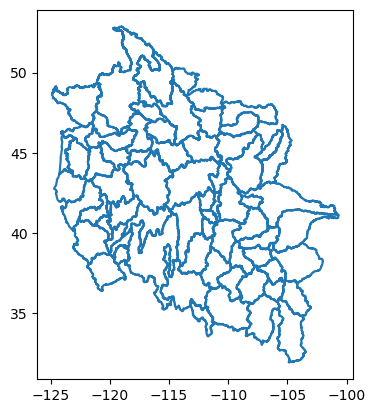

In [17]:
filtered_gdf.boundary.plot()